In [3]:
import pandas as pd

# Tải lên dữ liệu
df = pd.read_csv('/content/HAR dataset.csv')
df_reset = df.reset_index()
combined = df_reset.astype(str).agg(';'.join, axis=1)
df_split = combined.str.split(';', expand=True)

# Gán tên cột
df_split.columns = [
    'user', 'gender', 'age', 'height', 'weight', 'bmi',
    'x1', 'y1', 'z1',
    'x2', 'y2', 'z2',
    'x3', 'y3', 'z3',
    'x4', 'y4', 'z4',
    'extra1', 'extra2',
    'activity'
]

# Chuyển các cột cảm biến sang số
sensor_cols = df_split.columns[6:-1]
# Gán lại tên cột như trước
df_split.columns = [
    'user', 'gender', 'age', 'height', 'weight', 'bmi',
    'x1', 'y1', 'z1',
    'x2', 'y2', 'z2',
    'x3', 'y3', 'z3',
    'x4', 'y4', 'z4',
    'extra1', 'extra2',
    'activity'
]

# Chỉ chọn các cột cảm biến
sensor_cols = df_split.columns[6:-1]

# Tìm dòng có lỗi khi ép kiểu float
invalid_rows = df_split[sensor_cols].applymap(lambda x: not x.replace('.', '', 1).lstrip('-').isdigit()).any(axis=1)

# In ra số dòng bị lỗi
print("Số dòng lỗi:", invalid_rows.sum())

# Xóa dòng lỗi
df_clean = df_split[~invalid_rows].copy()

# Ép kiểu float cho các cột cảm biến
df_clean[sensor_cols] = df_clean[sensor_cols].astype(float)

# Xem kết quả
df_clean.head()



<ipython-input-3-12d77eec8639>:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  invalid_rows = df_split[sensor_cols].applymap(lambda x: not x.replace('.', '', 1).lstrip('-').isdigit()).any(axis=1)


Số dòng lỗi: 1


,user,gender,age,height,weight,bmi,x1,y1,z1,x2,...,z2,x3,y3,z3,x4,y4,z4,extra1,extra2,activity
0,debora,Woman,46,1,62,75,28.0,6.0,-3.0,92.0,...,-23.0,18.0,-19.0,5.0,104.0,-92.0,-150.0,-103.0,-147.0,sitting
1,debora,Woman,46,1,62,75,28.0,6.0,-3.0,94.0,...,-21.0,18.0,-18.0,-14.0,104.0,-90.0,-149.0,-104.0,-145.0,sitting
2,debora,Woman,46,1,62,75,28.0,6.0,-1.0,97.0,...,-12.0,20.0,-15.0,-13.0,104.0,-90.0,-151.0,-104.0,-144.0,sitting
3,debora,Woman,46,1,62,75,28.0,6.0,-2.0,96.0,...,-15.0,21.0,-16.0,-13.0,104.0,-89.0,-153.0,-103.0,-142.0,sitting
4,debora,Woman,46,1,62,75,28.0,6.0,-1.0,96.0,...,-13.0,20.0,-15.0,-13.0,104.0,-89.0,-153.0,-104.0,-143.0,sitting


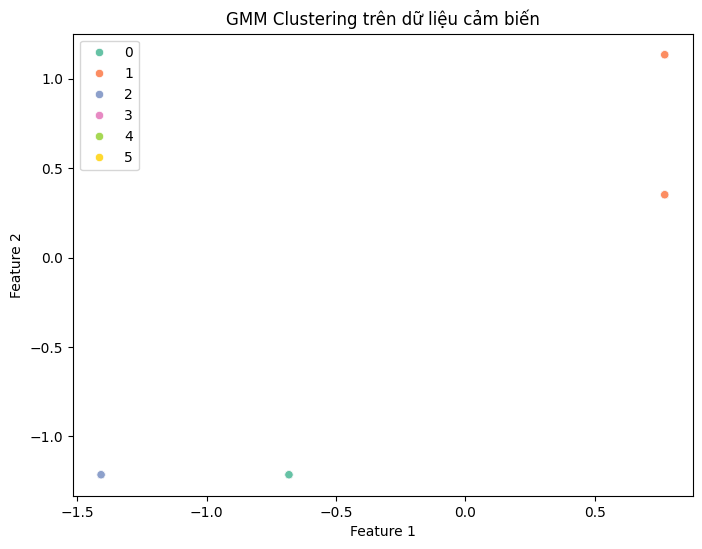

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chọn các cột dữ liệu cảm biến
sensor_cols = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
X = df_clean[sensor_cols]

# 2. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Áp dụng GMM (ví dụ: 6 cụm tương ứng 6 hoạt động)
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# 4. Gán nhãn cụm vào DataFrame
df_clean['gmm_label'] = gmm_labels

# 5. Trực quan hoá phân cụm (ví dụ theo 2 chiều đầu tiên)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=gmm_labels, palette='Set2')
plt.title('GMM Clustering trên dữ liệu cảm biến')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [6]:
# Tham số
window_size = 10

# Chuỗi nhãn số
labels = df_clean['gmm_label'].values

# Tạo dữ liệu đầu vào và nhãn đích
X, y = [], []
for i in range(len(labels) - window_size):
    X.append(labels[i:i+window_size])
    y.append(labels[i+window_size])

X = np.array(X)
y = np.array(y)

# Chuyển sang tensor
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

# Tập huấn luyện + DataLoader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [7]:
class TransformerModel(nn.Module):
    def __init__(self, num_classes, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, d_model]
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch, d_model]
        x = self.transformer(x)
        x = x[-1]  # dùng output cuối cùng
        out = self.fc(x)
        return out


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(num_classes=6, seq_len=window_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Huấn luyện
for epoch in range(10):  # bạn có thể tăng số epoch
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 631.6238
Epoch 2, Loss: 613.1049
Epoch 3, Loss: 607.7492
Epoch 4, Loss: 606.1831
Epoch 5, Loss: 603.4934
Epoch 6, Loss: 602.6253
Epoch 7, Loss: 601.2202
Epoch 8, Loss: 600.3062
Epoch 9, Loss: 599.5013
Epoch 10, Loss: 598.8576


In [9]:
model.eval()
sample_input = X_tensor[0].unsqueeze(0).to(device)  # lấy chuỗi đầu tiên
with torch.no_grad():
    pred = model(sample_input)
    predicted_label = pred.argmax(dim=1).item()

print("Chuỗi:", X_tensor[0].tolist())
print("Nhãn thực tế tiếp theo:", y_tensor[0].item())
print("Nhãn dự đoán:", predicted_label)



Chuỗi: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Nhãn thực tế tiếp theo: 1
Nhãn dự đoán: 1
